In [32]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.miscmodels.ordinal_model import OrderedModel
# import statsmodels.api as sm
# import statsmodels.formula.api as smf


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy import stats
from scipy.stats import t

In [33]:
df = pd.read_excel("../../data/df_scaled.xlsx")
df.head()

,TRANSACTION ID,FECHA NACIMIENTO,FECHA EXP DOC,NIVEL ESTUDIOS,ESTADOCIVIL,PROFESION,GÉNERO,TIPO VIVIENDA,NO PERSONAS A CARGO,ANTIGUEDAD EN LA CIUDAD tiempo en residencia,...,is_outlier_ml,SALDO VENCIDO_LOG,DIAS DE MORA _LOG,TOTAL INGRESOS_LOG,INGRESOS FIJOS_LOG,MONTO APROBADO_LOG,MONTO PREAPROBADO_LOG,NIVEL ESTUDIOS_ENC,ESTADOCIVIL_ENC,GÉNERO_ENC
0,2016918,1983-07-18,2001-07-27 05:00:00,Universitario,Soltero (a),Ingeniero,M,Familiar,-0.292162,-1.001090,...,1,0.0,0.0,1.568333,1.404903,0.871804,0.871804,8,2,1
1,2016914,1965-04-15,1983-08-16 05:00:00,Técnico,Soltero (a),Contador,F,Propia,-0.292162,1.453012,...,1,0.0,0.0,1.849846,1.838373,0.650738,0.650738,7,2,0
2,2016836,2005-01-25,2023-01-31 05:00:00,Técnico,Unión libre,Educador,F,Familiar,-0.292162,0.634978,...,1,0.0,0.0,-1.660744,-1.061758,0.340013,0.340013,7,3,0
3,2016736,1995-11-15,2013-11-28 00:00:00,Técnico,Unión libre,Asesor,F,Propia,-0.292162,-0.455734,...,1,0.0,0.0,0.564594,0.058590,0.495702,0.495702,7,3,0
4,2016576,2006-11-20,2024-11-27 00:00:00,Universitario,Soltero (a),Ingeniero,F,Propia,-0.292162,1.180334,...,1,0.0,0.0,1.612232,1.642078,0.428230,0.428230,8,2,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34156 entries, 0 to 34155
Data columns (total 66 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   TRANSACTION ID                                34156 non-null  int64         
 1   FECHA NACIMIENTO                              34156 non-null  datetime64[ns]
 2   FECHA EXP DOC                                 34156 non-null  datetime64[ns]
 3   NIVEL ESTUDIOS                                34156 non-null  object        
 4   ESTADOCIVIL                                   34156 non-null  object        
 5   PROFESION                                     34156 non-null  object        
 6   GÉNERO                                        34156 non-null  object        
 7   TIPO VIVIENDA                                 34156 non-null  object        
 8   NO PERSONAS A CARGO                           34156 non-null  floa

In [ ]:
selected_vars = [
    'SALDO VENCIDO_LOG', 'SCORE', 'ESTADOCIVIL', 'GÉNERO', 'NIVEL ESTUDIOS',
    'TOTAL INGRESOS_LOG', 'INGRESOS FIJOS_LOG', 'PASIVOS', 'ACTIVOS',
    'SALDO CAPITAL', 'AVAL', 'SEGURO', 'PLAZO', 'EDAD', 'ESTRATO', 'MONTO APROBADO_LOG'
]

df['MORA_ORD'] = pd.cut(
    df['DIAS DE MORA '],
    bins=[-1, 0, 30, 60, np.inf],   
    labels=[0, 1, 2, 3]
).astype(int)


# Variables independientes
X = df[selected_vars].copy()
X = pd.get_dummies(X, columns=['ESTADOCIVIL', 'GÉNERO', 'NIVEL ESTUDIOS'], drop_first=True)

# Variable dependiente
y = df['MORA_ORD'].astype(int)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [37]:
X_train_num = X_train.copy().astype(float)
X_test_num  = X_test.copy().astype(float)

modelo_ord = OrderedModel(
    y_train,
    X_train_num,
    distr='logit'
)

resultado = modelo_ord.fit(method='bfgs')
print(resultado.summary())

# Probabilidades por categoría
train_probs = resultado.predict(X_train_num)
test_probs  = resultado.predict(X_test_num)

Optimization terminated successfully.
         Current function value: 0.334799
         Iterations: 240
         Function evaluations: 250
         Gradient evaluations: 250
                             OrderedModel Results                             
Dep. Variable:               MORA_ORD   Log-Likelihood:                -9148.1
Model:                   OrderedModel   AIC:                         1.836e+04
Method:            Maximum Likelihood   BIC:                         1.860e+04
Date:                Fri, 14 Nov 2025                                         
Time:                        00:10:23                                         
No. Observations:               27324                                         
Df Residuals:                   27294                                         
Df Model:                          27                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----

In [38]:
y_train_pred = train_probs.values.argmax(axis=1)
y_test_pred  = test_probs.values.argmax(axis=1)

Accuracy train: 0.8962084614258528
Accuracy test: 0.8875878220140515


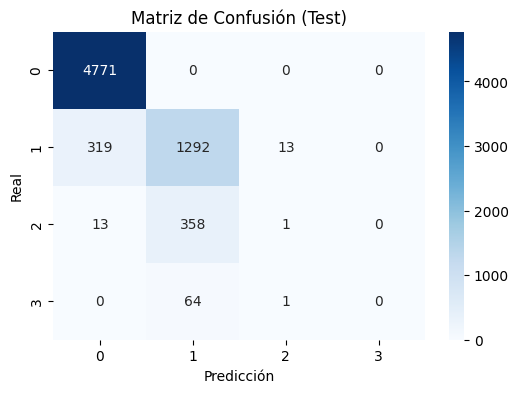

In [39]:
print("Accuracy train:", accuracy_score(y_train, y_train_pred))
print("Accuracy test:",  accuracy_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)

# Graficar con Seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()